<a href="https://colab.research.google.com/github/abood-W/ai_python/blob/main/Seales_predection_R2_0_933.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [447]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import to_timestamp, col
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [358]:
spark = SparkSession.builder.appName("MyApp").getOrCreate()

In [359]:
df = spark.read.csv("/content/sales_data_sample.csv", header=True, inferSchema=True)

In [360]:
df.show(8)

+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+-----------+----+-----------+--------------------+----------------+--------------------+------------+-------------+-----+----------+-------+---------+---------------+----------------+--------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES|      ORDERDATE| STATUS|QTR_ID|MONTH_ID|YEAR_ID|PRODUCTLINE|MSRP|PRODUCTCODE|        CUSTOMERNAME|           PHONE|        ADDRESSLINE1|ADDRESSLINE2|         CITY|STATE|POSTALCODE|COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|
+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+-----------+----+-----------+--------------------+----------------+--------------------+------------+-------------+-----+----------+-------+---------+---------------+----------------+--------+
|      10107|             30|     95.7|              2| 2871.0| 2/24/2003 0:00|Shipped| 

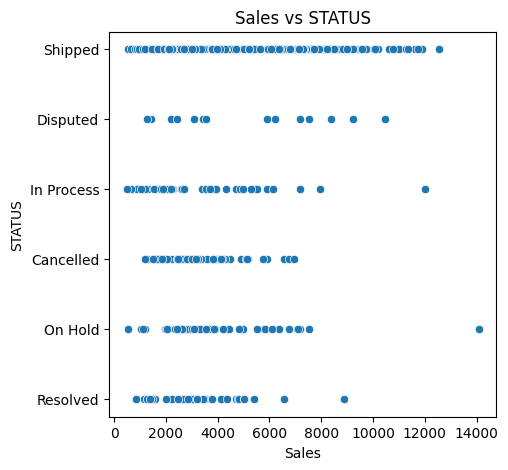

In [361]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='SALES', y='STATUS', data=df.toPandas())
plt.title('Sales vs STATUS')
plt.xlabel('Sales')
plt.ylabel('STATUS')
plt.show()

In [362]:
df =df.drop('PHONE','ORDERLINENUMBER','CUSTOMERNAME','ADDRESSLINE1','ADDRESSLINE2','CONTACTLASTNAME','STATUS','CONTACTFIRSTNAME','STATE','PRODUCTCODE')
df.dtypes
#,'POSTALCODE' 'TERRITORY',

[('ORDERNUMBER', 'int'),
 ('QUANTITYORDERED', 'int'),
 ('PRICEEACH', 'double'),
 ('SALES', 'double'),
 ('ORDERDATE', 'string'),
 ('QTR_ID', 'int'),
 ('MONTH_ID', 'int'),
 ('YEAR_ID', 'int'),
 ('PRODUCTLINE', 'string'),
 ('MSRP', 'int'),
 ('CITY', 'string'),
 ('POSTALCODE', 'string'),
 ('COUNTRY', 'string'),
 ('TERRITORY', 'string'),
 ('DEALSIZE', 'string')]

In [363]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="COUNTRY", outputCol="COUNTRY_int")
df = indexer.fit(df).transform(df)

#df.select("COUNTRY", "COUNTRY_int").show(5) ,


In [364]:
indexer = StringIndexer(inputCol="TERRITORY", outputCol="TERRITORY_int", handleInvalid="keep")
df = indexer.fit(df).transform(df)

In [365]:
indexer = StringIndexer(inputCol="POSTALCODE", outputCol="POSTALCODE_int", handleInvalid="keep")
df = indexer.fit(df).transform(df)

In [366]:
df =df.drop('TERRITORY','POSTALCODE')

In [367]:
df =df.drop('COUNTRY')

In [368]:
indexer = StringIndexer(inputCol="PRODUCTLINE", outputCol="PRODUCTLINE_int", handleInvalid="keep")
df = indexer.fit(df).transform(df)

In [369]:
df= df.drop('PRODUCTLINE')

In [370]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df =df.withColumn("ORDERDATE", to_timestamp(col("ORDERDATE"), "MM/dd/yyyy HH:mm"))

In [371]:
indexer = StringIndexer(inputCol="CITY", outputCol="CITY_int", handleInvalid="keep")
df = indexer.fit(df).transform(df)

In [372]:
df = df.drop('CITY')

In [373]:
indexer = StringIndexer(inputCol = "DEALSIZE", outputCol = "DEALSIZE_int", handleInvalid="keep")
df = indexer.fit(df).transform(df)

In [374]:
df =df.drop('DEALSIZE')

In [375]:
df.dtypes

[('ORDERNUMBER', 'int'),
 ('QUANTITYORDERED', 'int'),
 ('PRICEEACH', 'double'),
 ('SALES', 'double'),
 ('ORDERDATE', 'timestamp'),
 ('QTR_ID', 'int'),
 ('MONTH_ID', 'int'),
 ('YEAR_ID', 'int'),
 ('MSRP', 'int'),
 ('COUNTRY_int', 'double'),
 ('TERRITORY_int', 'double'),
 ('POSTALCODE_int', 'double'),
 ('PRODUCTLINE_int', 'double'),
 ('CITY_int', 'double'),
 ('DEALSIZE_int', 'double')]

**The data has been cleaned**

In [376]:

feature_cols = [
    'ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH',
    'QTR_ID',  'YEAR_ID', 'MSRP',
    'COUNTRY_int', 'TERRITORY_int',
     'CITY_int', 'DEALSIZE_int'
]

target_col = 'SALES'

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_vector = assembler.transform(df).select('features', target_col)

# **Convert to pandas , because XGBoost does not work dirictly with pyspark**

In [377]:
pandas_df = df_vector.toPandas()
X = np.array(pandas_df['features'].tolist())
y = pandas_df[target_col].values


In [378]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [437]:
model = xgb.XGBRegressor(
    n_estimators=210,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=62
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=210,
             n_jobs=None, num_parallel_tree=None, ...)

In [446]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

RMSE: 540.4781122336832
R2 Score: 0.9330758440385871


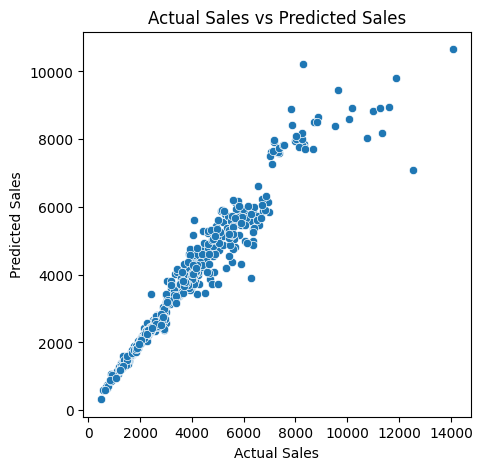

In [442]:
plot_df = pd.DataFrame({'Actual Sales': y_test, 'Predicted Sales': y_pred})

plt.figure(figsize=(5, 5))
sns.scatterplot(x='Actual Sales', y='Predicted Sales', data=plot_df)
plt.title('Actual Sales vs Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()